## PERC Rule for Pulmonary Embolism

### Seven Criteria of PERC Rule



1. Age < 50 years
2. Heart rate < 100 bpm
3. Oxygen saturation ≥ 95% 
4. No hemoptysis
5. No estrogen use
6. No prior venous thromboembolism (VTE)
7. No unilateral leg swelling

### Quick Overview

In [125]:
from datasets import load_dataset
import pandas as pd
import ast
import json
import matplotlib.pyplot as plt
import os
import requests
import sys
import re
import numpy as np
import asyncio
import aiohttp
from typing import List
import seaborn as sns
import builtins 

# Load dataset
dataset = load_dataset("ncbi/MedCalc-Bench-v1.0")
df = dataset["train"].to_pandas()  # or "test"
df_test = dataset["test"].to_pandas()  # or "test"
# Filter for calculator name "PERC"

perc_df = df[df["Calculator Name"] == "PERC Rule for Pulmonary Embolism"]

perc_df_test = df_test[df_test["Calculator Name"] == "PERC Rule for Pulmonary Embolism"]


### Function to calculate PERC Score

In [28]:
#Testing calcualtor
def perc_score(
    age,
    heart_rate,
    oxygen_saturation,
    has_hemoptysis=False,
    on_estrogen=False,
    history_dvt_pe=False,
    unilateral_leg_swelling=False,
    recent_trauma_or_surgery=False
):
    """
    Calculate the PERC rule score.
    Returns the number of failed criteria (0 = all passed, 8 = all failed).
    """
    score = 0
    if age >= 50:
        score += 1
    if heart_rate >= 100:
        score += 1
    if oxygen_saturation < 95:
        score += 1
    if has_hemoptysis:
        score += 1
    if on_estrogen:
        score += 1
    if history_dvt_pe:
        score += 1
    if unilateral_leg_swelling:
        score += 1
    if recent_trauma_or_surgery:
        
        score += 1
    return score


### Function to safely parse the "Relevant Entities" column

In [126]:

''''This function safely parses a string representation (val) of a dictionary or list similar to to_dict()'''
def safe_parse(val):
    if isinstance(val, dict):
        return val
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None

# Using perc_df["Relevant Entities"].to_dict() to parse the "Relevant Entities" column produces the same result as perc_df["Parsed Entities"].
perc_df["Parsed Entities"] = perc_df["Relevant Entities"].apply(safe_parse)


entities_df = pd.json_normalize(perc_df["Parsed Entities"])


def get_value(item):
    if isinstance(item, list) and item:
        return item[0]
    return item

entities_cleaned = entities_df.map(get_value)

'''This function extracts the first element from a list or returns the item itself if it's not a list.
Mainly to account for values with units such as ["73","years]'''
def extract_number(val):
    if isinstance(val, list) and len(val) > 0:
        return val[0]
    elif isinstance(val, (int, float)):
        return val
    else:
        return None
    
def calculate_perc_score_from_entities(entities):
    """Extracts values from entity dict and returns the computed PERC score."""
    age = extract_number(get_value(entities.get("age")))
    heart_rate = extract_number(get_value(entities.get("Heart Rate or Pulse")))
    o2_sat = extract_number(get_value(entities.get("O₂ saturation percentage")))

    hemoptysis = get_value(entities.get("Hemoptysis"), False)
    hormone_use = get_value(entities.get("Hormone use"), False)
    prior_pe_dvt = get_value(entities.get("Previously documented Deep Vein Thrombosis"), False) or \
                   get_value(entities.get("Previously Documented Pulmonary Embolism"), False)
    leg_swelling = get_value(entities.get("Unilateral Leg Swelling"), False)
    recent_surgery_trauma = get_value(entities.get("Recent surgery or trauma"), False)

    return perc_score(age, heart_rate, o2_sat, hemoptysis, hormone_use, prior_pe_dvt, leg_swelling, recent_surgery_trauma)


/var/folders/y5/cg9ckmtx691dkg8sg071p0qw0000gq/T/ipykernel_91983/1491001109.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perc_df["Parsed Entities"] = perc_df["Relevant Entities"].apply(safe_parse)


### Testing the Calculator 

In [30]:

#Quick test to see if the function works
wrong = 0
all_vals = 1000

for i in range(all_vals):
    sample_row = perc_df.sample(1).iloc[0]
    entities = sample_row["Parsed Entities"]

    if entities is None:
        # You can choose to skip or count this as wrong
        continue  # Skip this sample, or use: wrong += 1; continue

    def get_value(val, default=False):
        return val if val is not None else default

    try:
        score = calculate_perc_score_from_entities(entities)
    except Exception as e:
        print(f"❌ Error in sample {i}: {e}")
        print("Entities:", entities)
        wrong += 1
        continue

    if score != sample_row["Ground Truth Answer"]:
        print("Sample Entities:", entities)
        print("PERC Score with calculator:", score)
        print("Actual Ground Truth Answer:", sample_row["Ground Truth Answer"])
        print("-------" * 50)
        wrong += 1

print(wrong, "Incorrect answers out of", all)


0 Incorrect answers out of <built-in function all>


### Functions to run models

In [31]:
# Available models 
model_ids = [
    "Llama-3.3-70B-Instruct",#
    "Llama3-Med42-70B",#
    "Llama3-Med42-70B-32k",
    "Llama3-Med42-70B-DGX",
    "Llama3-Med42-DPO-70B",
    "Med42-Qwen2.5-72B-v3-bi",#
    "Med42-R1-Qwen3-4B",#
    "Meta-Llama-3-70B-Instruct",
    "Meta-Llama-3-70b-Instruct",
    # "gliner-gte-small",
    # "gliner-multitask-large-v0.5",
    # "gte-small",
    # "thenlper/gte-small",
    # "whisper-large-v3-turbo",
    # "whisper-large-v3-turbo-vllm"
]
#Models that I will be using
model_ids = [
    "Llama-3.3-70B-Instruct",#
    "Llama3-Med42-70B",#
    "Med42-Qwen2.5-72B-v3-bi"
]


### Function to run models with different prompts among other params and plot the data

In [32]:
'''extracts a JSON object from a text string. Assues only one JSON object is present in the text.'''
def extract_json_from_text(text: str):
    try:
        start = text.index('{')
        end = text.rindex('}') + 1
        json_str = text[start:end]
        return json.loads(json_str)
    except (ValueError, json.JSONDecodeError):
        return None
    


'''Attempts to extract a PERC score from a text string.
Returns a dictionary with "Answer" and optional "Note" keys.'''
def extract_score_from_text(text):
    if not isinstance(text, str):
        return None

    text = text.strip().lower()

    # Early rejection: misunderstood task
    rejection_keywords = [
        "not applicable", "cannot calculate", "not appropriate", "not designed",
        "does not apply", "score is not valid", "wrong score",
        "perc is not for", "perc (percutaneous|pneumonia|coronary|emergency)"
    ]
    if any(re.search(kw, text) for kw in rejection_keywords):
        return {"Answer": None, "Note": "LLM misunderstood or refused to calculate PERC score"}

    # Ensure correct PERC context
    if "pulmonary embolism" not in text and "perc criteria" in text:
        return {"Answer": None, "Note": "PERC criteria mentioned but not in PE context"}

    # Match known phrasing
    patterns = [
        r'\bperc\s*score\s*(?:is|=|of|:)?\s*(\d{1,2})\b',
        r'\btotal\s*score\s*(?:is|=|:)?\s*(\d{1,2})\b',
        r'\bscore\s*(?:is|=|:)?\s*(\d{1,2})\b',
        r'\banswer\s*(?:is|=|:)?\s*(\d{1,2})\b',
        r'\bmeets\s*(\d{1,2})\s+criteria',
        r'\b(\d{1,2})\s+criteria\s+met',
        r'\b(\d{1,2})\s+out\s+of\s+8\s+criteria',
        r'\b(\d{1,2})\s*/\s*8\s+criteria'
    ]
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            try:
                return {"Answer": int(match.group(1))}
            except ValueError:
                continue

    # Fallback 1: binary checklist count
    checklist_matches = re.findall(r':\s*([01])\b', text)
    if checklist_matches and len(checklist_matches) <= 8:
        try:
            score = sum(int(x) for x in checklist_matches)
            return {"Answer": score}
        except Exception:
            pass

    # Fallback 2: checklist-like marks
    checkbox_like = re.findall(r'-\s*\[(x|1)\]', text, re.IGNORECASE)
    if checkbox_like:
        return {"Answer": len(checkbox_like)}

    # Fallback 3: keyword-based approximate tally
    yes_count = len(re.findall(r'\b(yes|1|true|present)\b', text, re.IGNORECASE))
    no_count = len(re.findall(r'\b(no|0|false|absent)\b', text, re.IGNORECASE))
    if 0 < yes_count <= 8 and yes_count + no_count >= 5:
        return {"Answer": yes_count, "Note": "Heuristically inferred from 'yes' counts"}

    return {"Answer": None, "Note": "No identifiable score"}

'''Plots a bar chart comparing the counts of correct, wrong, and invalid answers for each model.'''
def plot_df(results_df):
    x = np.arange(len(results_df))  # label locations
    width = 0.25  # narrower bar width to fit 3 bars per group

    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(x - width,     results_df["correct"], width, label='Correct', color='mediumseagreen')
    bars2 = ax.bar(x,             results_df["wrong"],   width, label='Wrong',   color='tomato')
    bars3 = ax.bar(x + width,     results_df["invalid"], width, label='Invalid', color='slategray')

    ax.set_title("Correct, Wrong, and Invalid Answer Count per Model")
    ax.set_xlabel("Model")
    ax.set_ylabel("Count")
    ax.set_xticks(x)
    ax.set_xticklabels(results_df["model_id"], rotation=45, ha="right")
    ax.legend()
    ax.grid(axis="y", linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


'''Plots a pie chart for each model showing the distribution of correct, wrong, and invalid answers.'''
def plot_df_pie(results_df):
    num_models = len(results_df)
    ncols = 2
    nrows = (num_models + 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))
    axes = axes.flatten()

    for i, row in results_df.iterrows():
        # Prepare label, value, color triplets
        all_labels = ['Correct', 'Incorrect', 'Invalid']
        all_counts = [row['correct'], row['wrong'], row['invalid']]
        all_colors = ['mediumseagreen', 'tomato', 'slategray']

        # Filter out zero-counts
        filtered = [(label, count, color) for label, count, color in zip(all_labels, all_counts, all_colors) if count > 0]
        if not filtered:
            continue  # skip completely empty pie

        labels, counts, colors = zip(*filtered)

        ax = axes[i]
        ax.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
        ax.set_title(f"Model: {row['model_id']}")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Prediction Outcome Breakdown per Model", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()





In [ ]:

# Configuration
BASE_URL = "https://hive.g42healthcare.ai/v1/chat/completions"
HEADERS = {"Content-Type": "application/json"}
CONCURRENT_REQUESTS = 10  # Limit the number of parallel requests

# Async function to get LLM response
'''Async function to get chat completion from the LLM API. Takes in a session, semaphore, model ID, system instruction, and user instruction.
Returns the content of the first choice in the response.'''
async def get_chat_completion(session, sem, model: str, system_instruction: str, user_instruction: str) -> str:
    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": system_instruction},
            {"role": "user", "content": user_instruction}
        ],
        "temperature": 0.0,
        "stream": False,
        "max_tokens": 2000
    }

    async with sem:
        async with session.post(BASE_URL, headers=HEADERS, json=payload) as response:
            response.raise_for_status()
            result = await response.json()
            return result["choices"][0]["message"]["content"]

''' A function that runs a batch of prompts concurrently using asyncio and aiohttp.
It takes a model ID, system instruction, and a list of prompts, and returns the results.
It uses a semaphore to limit the number of concurrent requests.'''
async def run_batch(model: str, system_instruction: str, prompts: List[str]):
    sem = asyncio.Semaphore(CONCURRENT_REQUESTS)
    async with aiohttp.ClientSession() as session:
        tasks = [
            get_chat_completion(session, sem, model, system_instruction, prompt)
            for prompt in prompts
        ]

        results = []
        total = len(tasks)
        completed = 0

        for coro in asyncio.as_completed(tasks):
            result = await coro
            results.append(result)
            completed += 1
            progress = (completed / total) * 100
            print(f"\rBatch Progress: {progress:.1f}% ({completed}/{total})", end="", flush=True)

        print()  # newline after completion
        return results


In [ ]:
''' A function that runs models with output.
It takes a system instruction, a list of model IDs, and optional parameters for including relevant entities,
sampling, and full DataFrame usage.
It returns invalid outputs, wrong outputs, a summary DataFrame, and parsed results per model.'''
async def run_models_with_output_with_jinja(
    sys_instruct,
    model_ids: List[str],
    include_relevant_entities=True,
    sample=10,
    full_df=False,
    prompt="Calculate PERC score for this patient."
):
    results = []
    wrong_outputs = []
    invalid_outputs = []
    parsed_results_per_model = {model_id: [] for model_id in model_ids}

    subset_df = perc_df.head(sample)
    iterate_df = perc_df if full_df else subset_df

    for model_id in model_ids:
        print(f"\n=== Evaluating model: {model_id} ===\n")
        wrong = invalid = correct = 0
        total = len(iterate_df)
        prompts = []

        for idx, row in iterate_df.iterrows():
            entities = entities = ast.literal_eval(row["Relevant Entities"]) if include_relevant_entities else None
            user_instruction = template.render(
                note=row["Patient Note"],
                entities=row["Parsed Entities"],
                include_relevant_entities=include_relevant_entities,
                prompt=prompt
            )
            prompts.append(user_instruction)


        results_async = await run_batch(
            model=model_id,
            system_instruction=sys_instruct,
            prompts=prompts
        )

        for i, reply in enumerate(results_async):
            progress = (i + 1) / len(results_async) * 100
            print(f"\rParsing: {progress:.1f}% ({i + 1}/{len(results_async)})", end="", flush=True)

            row = iterate_df.iloc[i]
            entities = row["Parsed Entities"]
            ground_truth = row["Ground Truth Answer"]

            parsed = extract_json_from_text(reply)
            if parsed is None or "Answer" not in parsed:
                # parsed = extract_score_from_text(reply) 
                if parsed is None or "Answer" not in parsed:
                    invalid += 1
                    invalid_outputs.append({
                        "model": model_id,
                        "note": row["Patient Note"],
                        "entities": entities if include_relevant_entities else None,
                        "reply": reply,
                        "reason": "Invalid JSON or missing 'Answer'"
                    })
                    parsed_results_per_model[model_id].append({
                        "note": row["Patient Note"],
                        "entities": entities if include_relevant_entities else None,
                        "ground_truth": ground_truth,
                        "parsed_criteria": None,
                        "predicted": None,
                        "raw_reply": reply,
                        "valid": False,
                        "correct": False
                    })
                    continue

            predicted_score = parsed.get("Answer")

            # Extract all criteria booleans except the 'Answer'
            criteria = {k: v for k, v in parsed.items() if k != "Answer"}

            if predicted_score == ground_truth:
                correct += 1
            else:
                wrong += 1
                wrong_outputs.append({
                    "model": model_id,
                    "note": row["Patient Note"],
                    "entities": entities if include_relevant_entities else None,
                    "reply": reply,
                    "expected": ground_truth,
                    "predicted": predicted_score
                })

            parsed_results_per_model[model_id].append({
                "note": row["Patient Note"],
                "entities": entities if include_relevant_entities else None,
                "ground_truth": ground_truth,
                "parsed_criteria": criteria,
                "predicted": predicted_score,
                "raw_reply": reply,
                "valid": True,
                "correct": predicted_score == ground_truth
            })

        valid = correct + wrong
        accuracy = correct / valid if valid > 0 else 0

        results.append({
            "model_id": model_id,
            "wrong": wrong,
            "correct": correct,
            "invalid": invalid,
            "total": total,
            "accuracy": round(accuracy, 3)
        })

        print("\nDone ✅")

    results_df = pd.DataFrame(results)
    print("\n=== Summary Table ===")
    print(results_df)

    return invalid_outputs, wrong_outputs, results_df, parsed_results_per_model


### Testing Function with different prompts

#### Simple prompt (includes all relevant entites in prompt)


=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Llama3-Med42-70B ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Med42-Qwen2.5-72B-v3-bi ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Summary Table ===
                  model_id  wrong  correct  invalid  total  accuracy
0   Llama-3.3-70B-Instruct    118       15        0    133     0.113
1         Llama3-Med42-70B    103       30        0    133     0.226
2  Med42-Qwen2.5-72B-v3-bi    106       27        0    133     0.203


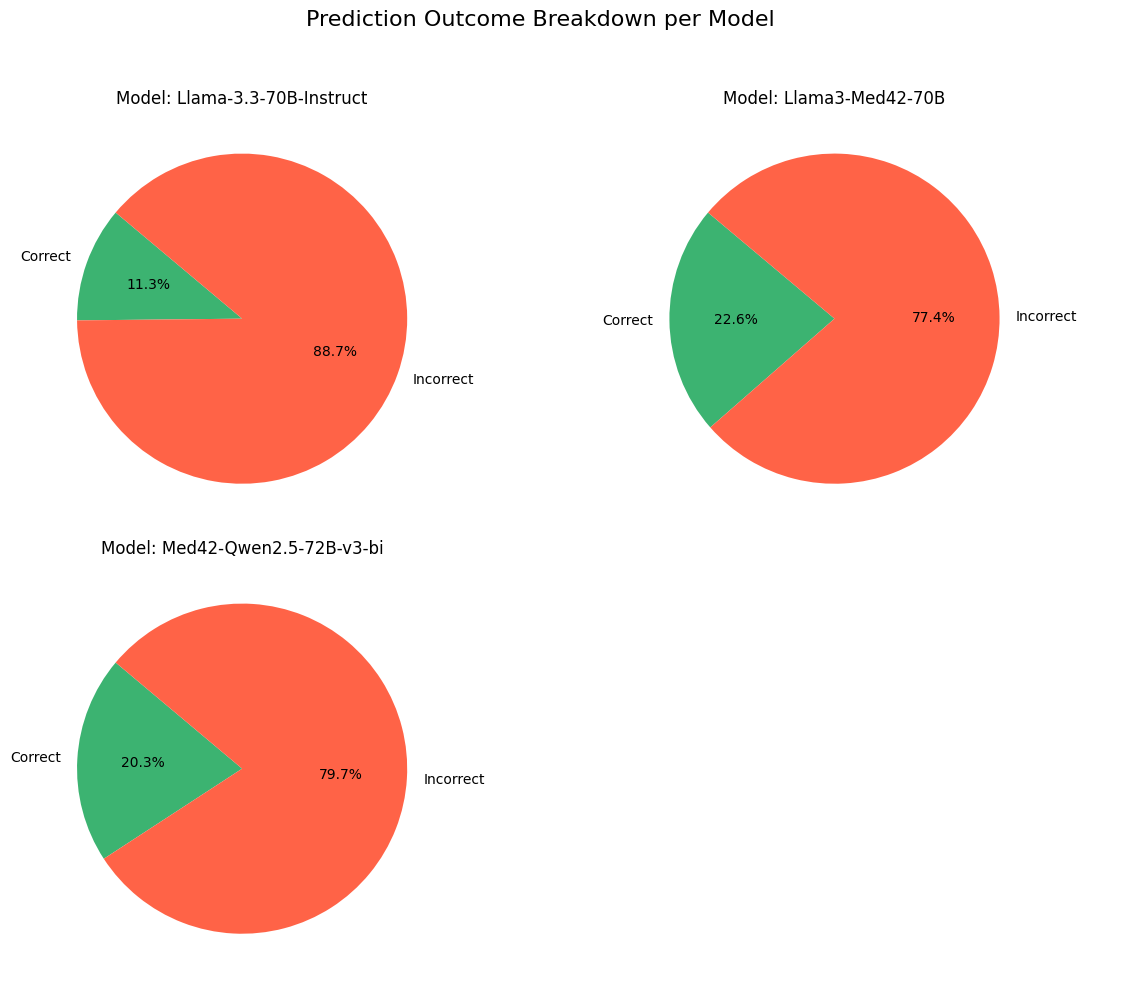

In [34]:
invalid_outputs, wrong_outputs, results_df,parsed_json = await run_models_with_output(
    sys_instruct=(
        "You are a helpful Medical Assistant. After you calculate the PERC score, provide an explanation of how "
        "you arrived at that score along with the score in JSON format. \n"
        "The JSON should be in the format: {\"Explanation\": \"<explanation>\", \"Answer\": <score>}"
    ),
    model_ids=model_ids,
    include_relevant_entities=True,
    full_df=True
)
plot_df_pie(results_df)


#### Simple prompt (does not include relevant entites in prompt)


=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Llama3-Med42-70B ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Med42-Qwen2.5-72B-v3-bi ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Summary Table ===
                  model_id  wrong  correct  invalid  total  accuracy
0   Llama-3.3-70B-Instruct    115       18        0    133     0.135
1         Llama3-Med42-70B    108       25        0    133     0.188
2  Med42-Qwen2.5-72B-v3-bi    107       26        0    133     0.195


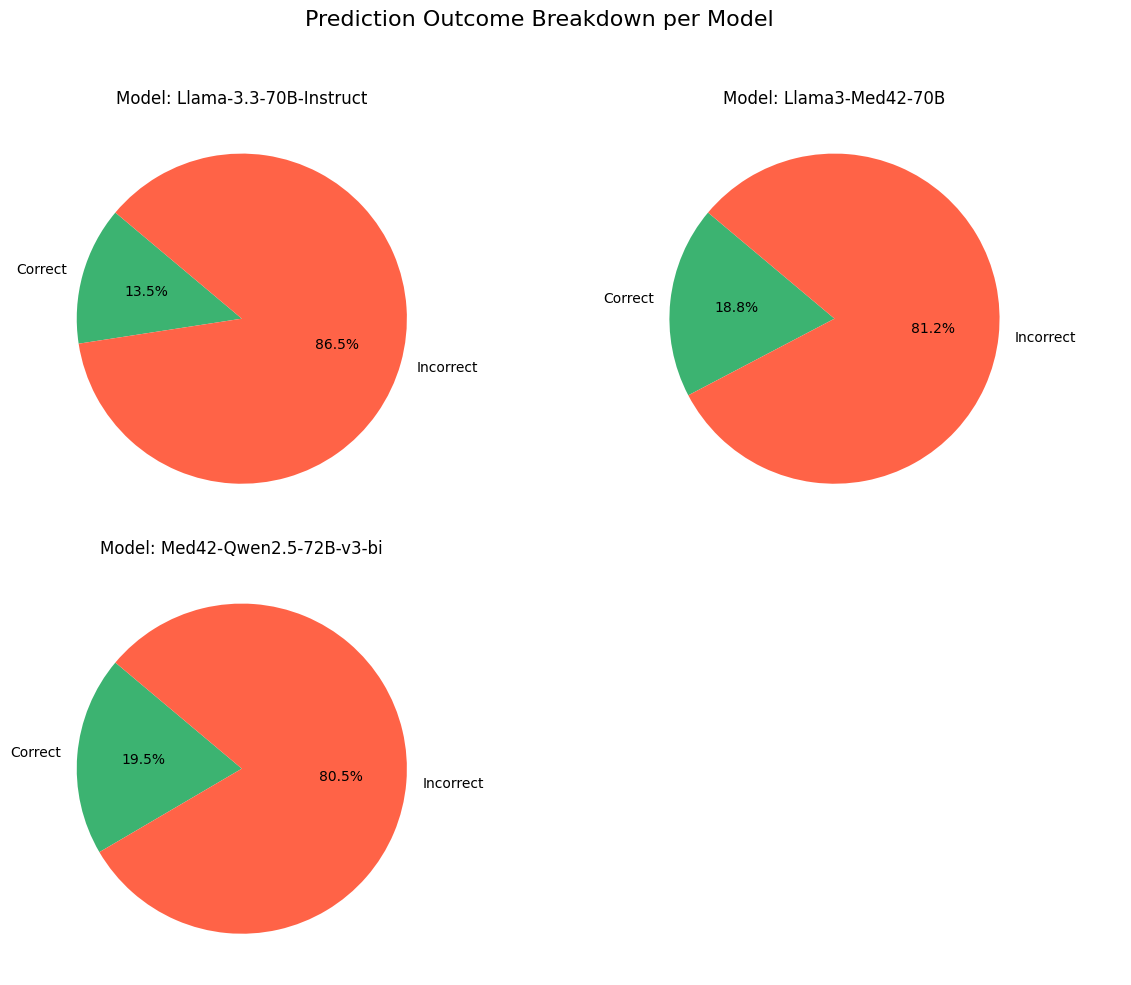

In [35]:
invalid_outputs, wrong_outputs, results_df,parsed_json = await run_models_with_output(
    sys_instruct=(
        "You are a helpful Medical Assistant. After you calculate the PERC score, provide an explanation of how "
        "you arrived at that score along with the score in JSON format. \n"
        "The JSON should be in the format: {\"Explanation\": \"<explanation>\", \"Answer\": <score>}"
    ),
    model_ids=model_ids,
    include_relevant_entities=False,
    full_df=True
)
plot_df_pie(results_df)


#### Troubleshooting wrong/invalid replies

In [76]:
def print_outputs(wrong_outputs,invalid_outputs):
    for i, entry in enumerate(wrong_outputs):
        print(f"\n--- Wrong Reply {i+1} ---")
        print(f"Expected: {entry['expected']} | Predicted: {entry['predicted']}")
        print(f"Reply:\n{entry['reply']}")

    # Extract invalid replies with metadata
    for i, entry in enumerate(invalid_outputs):
        print(f"\n--- Invalid Reply {i+1} ---")
        print(f"Expected: {entry['expected']} | Predicted: {entry['predicted']}")
        print(f"Reply:\n{entry['reply']}")

# invalid_replies = [entry['reply'] for entry in invalid_outputs if 'reply' in entry]
# for i, reply in enumerate(invalid_replies):
#     print(f"\n--- Invalid Reply {i+1} ---\n{reply}")


#### More detailed system instruction (includes relevant entities in prompt)


=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Llama3-Med42-70B ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Med42-Qwen2.5-72B-v3-bi ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Summary Table ===
                  model_id  wrong  correct  invalid  total  accuracy
0   Llama-3.3-70B-Instruct    103       30        0    133     0.226
1         Llama3-Med42-70B     95       38        0    133     0.286
2  Med42-Qwen2.5-72B-v3-bi     99       34        0    133     0.256


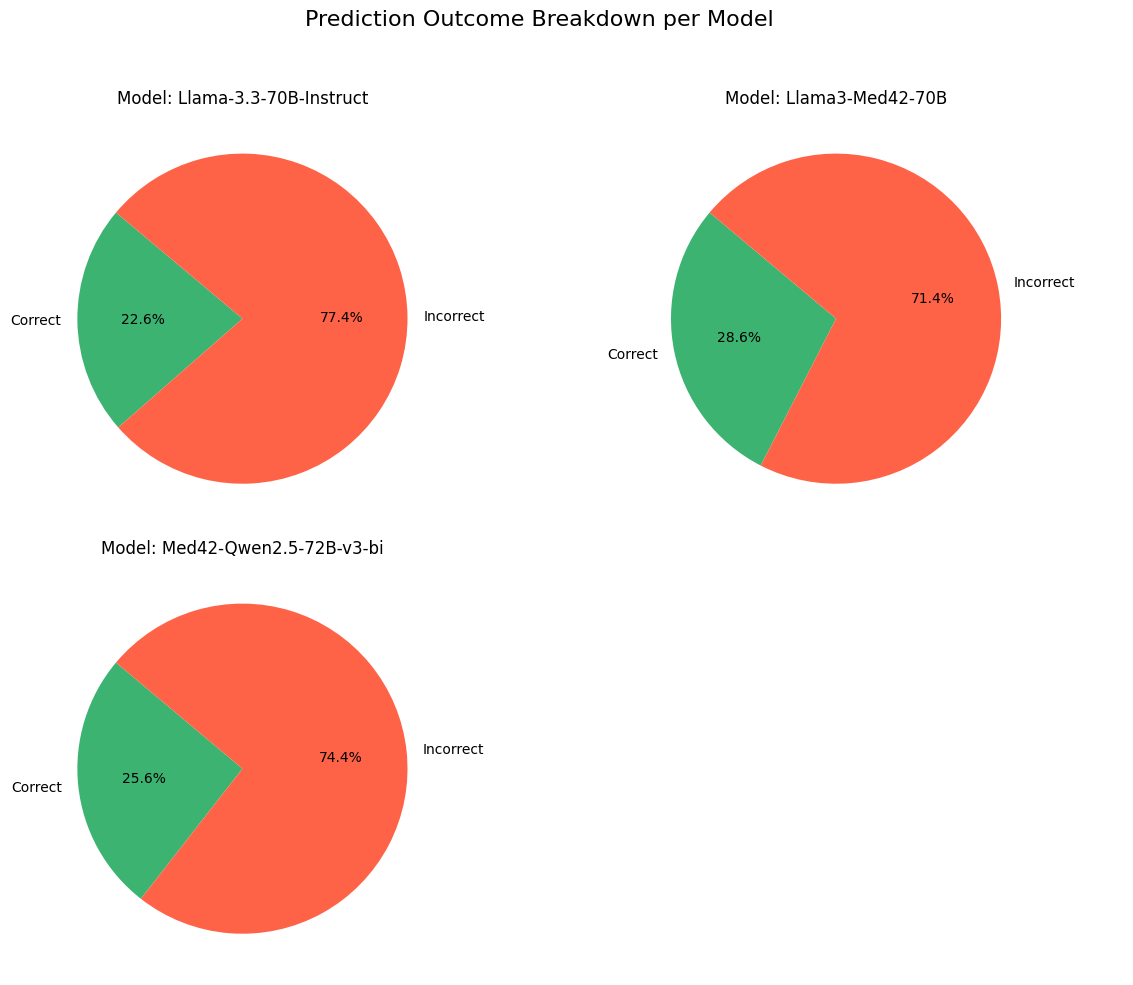

In [37]:
sys_instruct = (
    "You are a clinical decision support assistant.\n"
    "\n"
    "Your task is to calculate the PERC (Pulmonary Embolism Rule-out Criteria) score for a patient using the note and extracted entities provided.\n"
    "\n"
    "There are 7 criteria. Each one is evaluated as either true (criterion met) or false (criterion not met). Each false criterion adds 1 point to the PERC score.\n"
    "\n"
    "PERC Criteria:\n"
    "1. Age < 50 years\n"
    "2. Heart rate < 100 bpm\n"
    "3. Oxygen saturation ≥ 95%\n"
    "4. No hemoptysis\n"
    "5. No estrogen use\n"
    "6. No prior venous thromboembolism (VTE)\n"
    "7. No unilateral leg swelling\n"
    "\n"
    "After your output return a **single JSON object*.\n"
    "\n"
    "Format:\n"
    "{\n"
    "  \"Explanation\": \"<A short explanation of how each criterion was evaluated>\",\n"
    "  \"Criteria\": {\n"
    "    \"Age < 50\": true or false,\n"
    "    \"HR < 100\": true or false,\n"
    "    \"O₂ ≥ 95%\": true or false,\n"
    "    \"No hemoptysis\": true or false,\n"
    "    \"No estrogen use\": true or false,\n"
    "    \"No prior VTE\": true or false,\n"
    "    \"No unilateral leg swelling\": true or false\n"
    "  },\n"
    "  \"Answer\": <sum of false values>\n"
    "}\n"
    "\n"

)
invalid_outputs, wrong_outputs, results_df,parsed_json = await run_models_with_output(
    sys_instruct = sys_instruct
    ,prompt="Calculate the PERC score for this patient based on the 7 criteria above. Explain how each criterion applies, then return the result in the specified JSON format.",
    model_ids=model_ids,
    include_relevant_entities=True,
    full_df=True
)
plot_df_pie(results_df)


#### More detailed system instruction (does not include relevant entities in prompt)


=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Llama3-Med42-70B ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Med42-Qwen2.5-72B-v3-bi ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Summary Table ===
                  model_id  wrong  correct  invalid  total  accuracy
0   Llama-3.3-70B-Instruct    103       30        0    133     0.226
1         Llama3-Med42-70B     95       38        0    133     0.286
2  Med42-Qwen2.5-72B-v3-bi    106       27        0    133     0.203


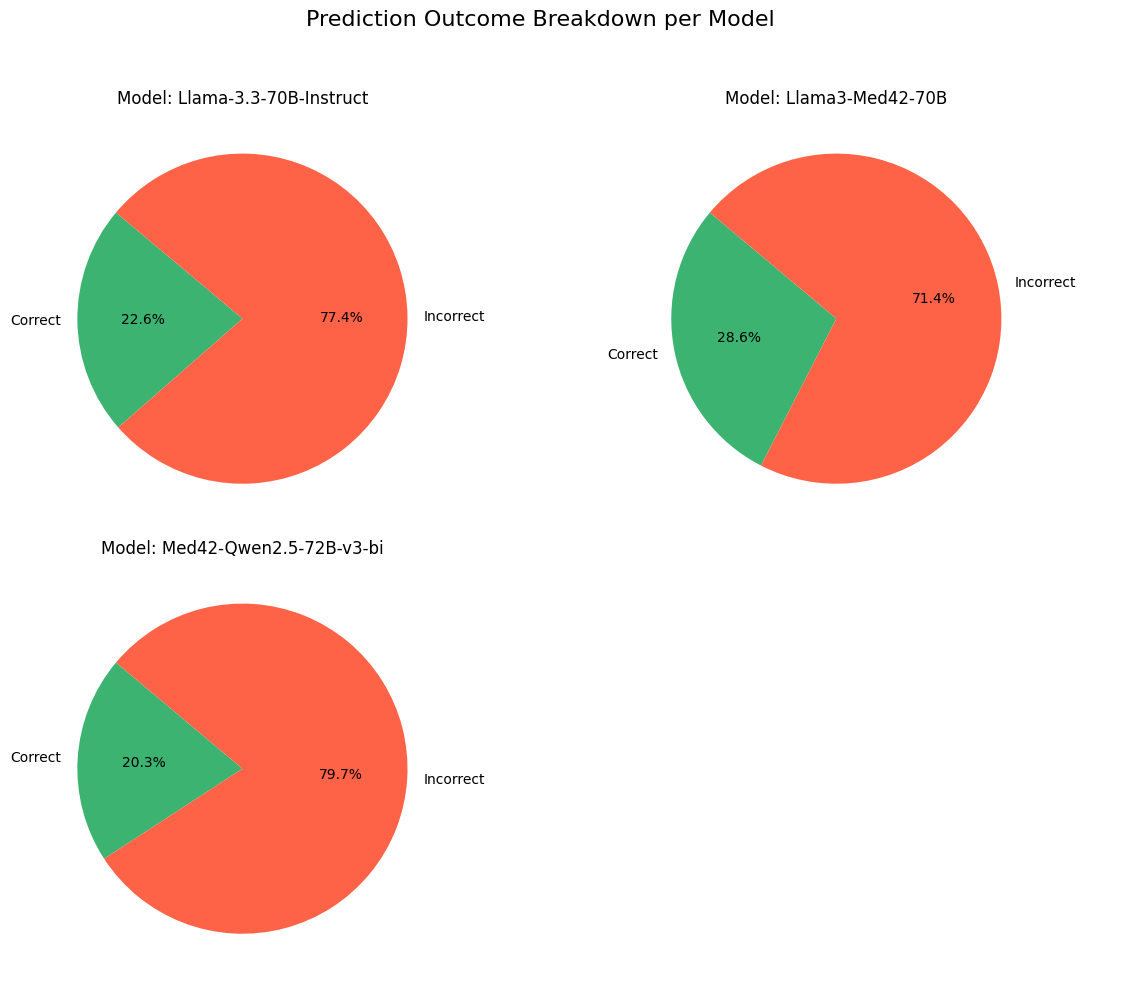

In [38]:
sys_instruct = (
    "You are a clinical decision support assistant.\n"
    "\n"
    "Your task is to calculate the PERC (Pulmonary Embolism Rule-out Criteria) score for a patient using the note and extracted entities provided.\n"
    "\n"
    "There are 7 criteria. Each one is evaluated as either true (criterion met) or false (criterion not met). Each false criterion adds 1 point to the PERC score.\n"
    "\n"
    "PERC Criteria:\n"
    "1. Age < 50 years\n"
    "2. Heart rate < 100 bpm\n"
    "3. Oxygen saturation ≥ 95%\n"
    "4. No hemoptysis\n"
    "5. No estrogen use\n"
    "6. No prior venous thromboembolism (VTE)\n"
    "7. No unilateral leg swelling\n"
    "\n"
    "After your output return a **single JSON object*.\n"
    "\n"
    "Format:\n"
    "{\n"
    "  \"Explanation\": \"<A short explanation of how each criterion was evaluated>\",\n"
    "  \"Criteria\": {\n"
    "    \"Age < 50\": true or false,\n"
    "    \"HR < 100\": true or false,\n"
    "    \"O₂ ≥ 95%\": true or false,\n"
    "    \"No hemoptysis\": true or false,\n"
    "    \"No estrogen use\": true or false,\n"
    "    \"No prior VTE\": true or false,\n"
    "    \"No unilateral leg swelling\": true or false\n"
    "  },\n"
    "  \"Answer\": <sum of false values>\n"
    "}\n"
    "\n"

)
invalid_outputs, wrong_outputs, results_df,parsed_json = await run_models_with_output(
    sys_instruct = sys_instruct
    ,prompt="Calculate the PERC score for this patient based on the 7 criteria above. Explain how each criterion applies, then return the result in the specified JSON format.",
    model_ids=model_ids,
    include_relevant_entities=False,
    full_df=True
)
plot_df_pie(results_df)


### Accuracy (Used the data from "More detailed system instruction (does not include relevant entities in prompt)")

#### Outputs and Ground truth answer

In [39]:
''' A function that computes the truth table for the PERC criteria based on parsed JSON outputs and patient data.
It returns a DataFrame with accuracy for each criterion per model.'''
def compute_truth_table(parsed_json, patient_df):
    rows = []

    def to_bool(val):
        if isinstance(val, bool):
            return val
        if isinstance(val, str):
            return val.lower() in ['true', 'yes', '1']
        return bool(val)

    for model_id, outputs in parsed_json.items():
        for i, output in enumerate(outputs):
            try:
                criteria_pred = output["parsed_criteria"]["Criteria"]
            except (TypeError, KeyError):
                continue  # skip bad or invalid outputs

            row = patient_df.iloc[i]
            entities = row["Parsed Entities"]

            age = extract_number(entities.get("age"))
            hr = extract_number(entities.get("Heart Rate or Pulse"))
            o2 = extract_number(entities.get("O₂ saturation percentage"))

            truth = {
                "Age < 50": age is not None and age < 50,
                "HR < 100": hr is not None and hr < 100,
                "O₂ ≥ 95%": o2 is not None and o2 >= 95,
                "No hemoptysis": not to_bool(entities.get("Hemoptysis", False)),
                "No estrogen use": not to_bool(entities.get("Estrogen use", False)),
                "No prior VTE": not to_bool(entities.get("Prior VTE", False)),
                "No unilateral leg swelling": not to_bool(entities.get("Unilateral leg swelling", False)),
            }

            for criterion, true_val in truth.items():
                pred_val = criteria_pred.get(criterion)
                match = (pred_val == true_val)
                rows.append({
                    "Model": model_id,
                    "Criterion": criterion,
                    "Correct": match
                })

    df = pd.DataFrame(rows)

    # Group by model and criterion, compute mean accuracy
    accuracy_df = (
        df.groupby(["Model", "Criterion"])["Correct"]
        .mean()
        .reset_index()
        .pivot(index="Criterion", columns="Model", values="Correct")
        .round(3)
    )

    return accuracy_df


In [40]:
accuracy_table = compute_truth_table(parsed_json, perc_df)
print(accuracy_table)


Model                       Llama-3.3-70B-Instruct  Llama3-Med42-70B  \
Criterion                                                              
Age < 50                                     0.534             0.563   
HR < 100                                     0.556             0.563   
No estrogen use                              0.947             0.849   
No hemoptysis                                0.880             0.889   
No prior VTE                                 0.955             0.810   
No unilateral leg swelling                   0.917             0.810   
O₂ ≥ 95%                                     0.541             0.595   

Model                       Med42-Qwen2.5-72B-v3-bi  
Criterion                                            
Age < 50                                      0.481  
HR < 100                                      0.426  
No estrogen use                               0.891  
No hemoptysis                                 0.868  
No prior VTE               

In [41]:
'''A function that plots confusion matrices for each model and criterion based on parsed JSON outputs and patient data.
It creates a grid of subplots with each model's confusion matrix for each criterion.'''
def plot_confusion_matrices_by_model(parsed_json, patient_df):
    def to_bool(val):
        if isinstance(val, bool):
            return val
        if isinstance(val, str):
            return val.lower() in ['true', 'yes', '1']
        return bool(val)

    data = []

    for model_id, outputs in parsed_json.items():
        for i, output in enumerate(outputs):
            try:
                criteria_pred = output["parsed_criteria"]["Criteria"]
            except (TypeError, KeyError):
                continue

            row = patient_df.iloc[i]
            entities = row["Parsed Entities"]

            age = extract_number(entities.get("age"))
            hr = extract_number(entities.get("Heart Rate or Pulse"))
            o2 = extract_number(entities.get("O₂ saturation percentage"))

            truth = {
                "Age < 50": age is not None and age < 50,
                "HR < 100": hr is not None and hr < 100,
                "O₂ ≥ 95%": o2 is not None and o2 >= 95,
                "No hemoptysis": not to_bool(entities.get("Hemoptysis", False)),
                "No estrogen use": not to_bool(entities.get("Estrogen use", False)),
                "No prior VTE": not to_bool(entities.get("Prior VTE", False)),
                "No unilateral leg swelling": not to_bool(entities.get("Unilateral leg swelling", False)),
            }

            for criterion, true_val in truth.items():
                pred_val = criteria_pred.get(criterion)
                if pred_val is None:
                    continue
                data.append({
                    "Model": model_id,
                    "Criterion": criterion,
                    "True": true_val,
                    "Pred": pred_val,
                })

    df = pd.DataFrame(data)

    models = df["Model"].unique()
    criteria = df["Criterion"].unique()

    nrows = len(models)
    ncols = len(criteria)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)

    for i, model in enumerate(models):
        for j, criterion in enumerate(criteria):
            ax = axes[i][j]
            sub = df[(df["Model"] == model) & (df["Criterion"] == criterion)]
            cm = pd.crosstab(sub["True"], sub["Pred"])
            sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues", ax=ax)
            ax.set_title(f"{model} — {criterion}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


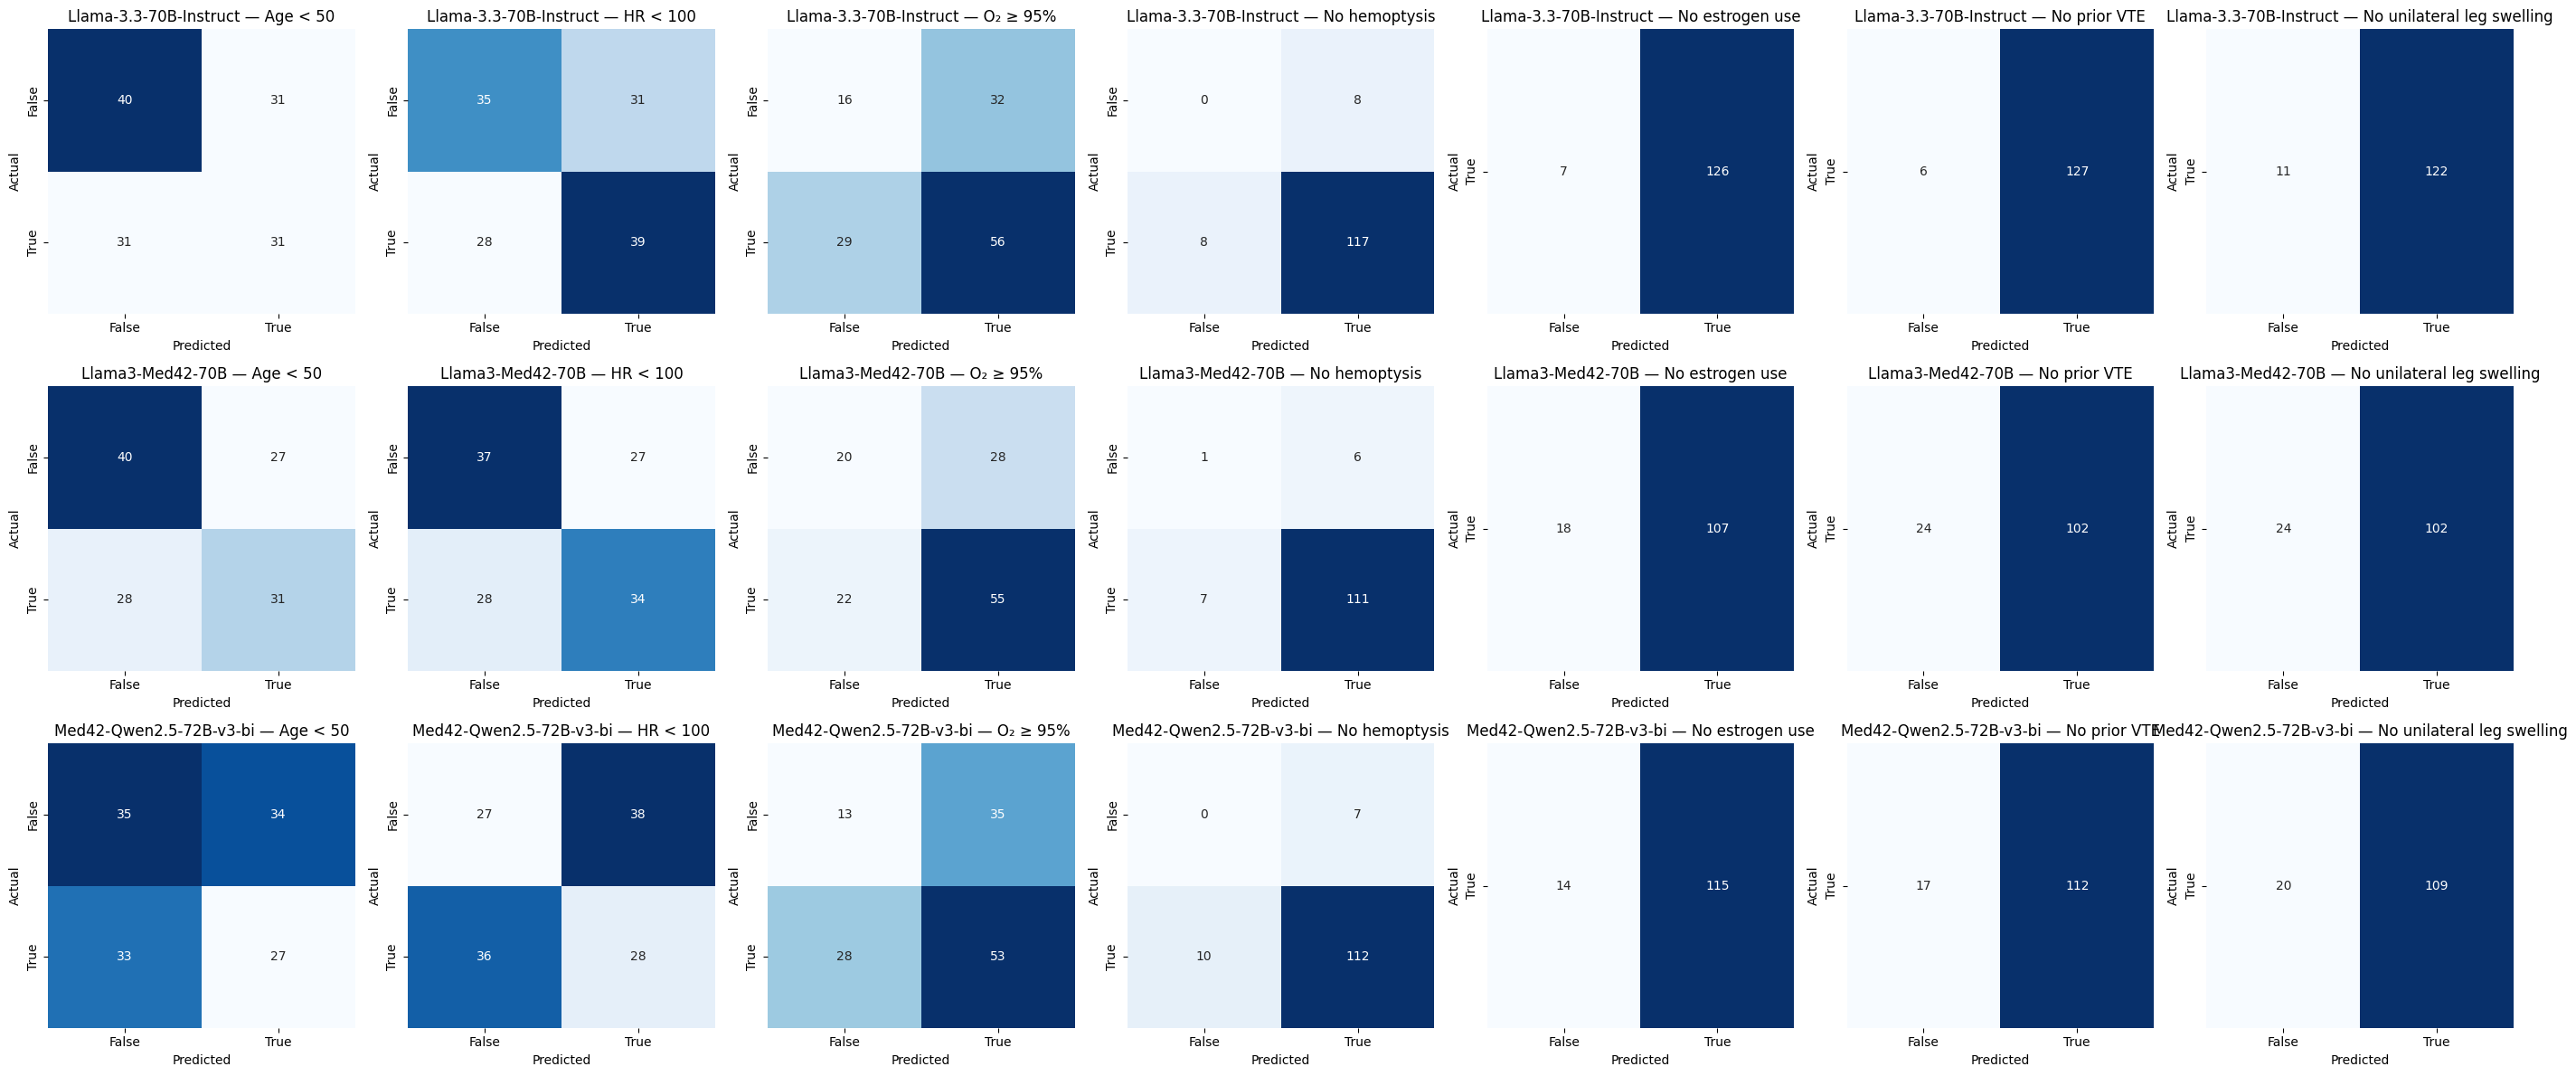

In [42]:
plot_confusion_matrices_by_model(parsed_json, perc_df)

In [43]:
''' A function that plots the accuracy of PERC criteria by outcome (correct or incorrect) for each model.
It creates a heatmap for each outcome type, showing the accuracy of each criterion per model.'''
def plot_criteria_accuracy_by_outcome(parsed_json, patient_df):
    def to_bool(val):
        if isinstance(val, bool):
            return val
        if isinstance(val, str):
            return val.lower() in ['true', 'yes', '1']
        return bool(val)

    def compute_data(filter_correct: bool):
        rows = []
        for model_id, outputs in parsed_json.items():
            for i, output in enumerate(outputs):
                if output.get("correct") != filter_correct:
                    continue

                try:
                    criteria_pred = output["parsed_criteria"]["Criteria"]
                except (TypeError, KeyError):
                    continue

                row = patient_df.iloc[i]
                entities = row["Parsed Entities"]

                age = extract_number(entities.get("age"))
                hr = extract_number(entities.get("Heart Rate or Pulse"))
                o2 = extract_number(entities.get("O₂ saturation percentage"))

                truth = {
                    "Age < 50": age is not None and age < 50,
                    "HR < 100": hr is not None and hr < 100,
                    "O₂ ≥ 95%": o2 is not None and o2 >= 95,
                    "No hemoptysis": not to_bool(entities.get("Hemoptysis", False)),
                    "No estrogen use": not to_bool(entities.get("Estrogen use", False)),
                    "No prior VTE": not to_bool(entities.get("Prior VTE", False)),
                    "No unilateral leg swelling": not to_bool(entities.get("Unilateral leg swelling", False)),
                }

                for criterion, true_val in truth.items():
                    pred_val = criteria_pred.get(criterion)
                    if pred_val is None:
                        continue
                    match = (pred_val == true_val)
                    rows.append({
                        "Model": model_id,
                        "Criterion": criterion,
                        "CorrectCriterion": match
                    })

        return pd.DataFrame(rows)

    # Get data for both correct and incorrect predictions
    correct_df = compute_data(filter_correct=True)
    incorrect_df = compute_data(filter_correct=False)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    for df, ax, title in zip(
        [correct_df, incorrect_df],
        axes,
        ["Given Correct Final Answer", "Given Incorrect Final Answer"]
    ):
        if df.empty:
            ax.set_visible(False)
            continue

        summary = (
            df.groupby(["Model", "Criterion"])["CorrectCriterion"]
            .mean()
            .reset_index()
            .pivot(index="Criterion", columns="Model", values="CorrectCriterion")
            .round(3)
        )

        sns.heatmap(summary, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1, cbar=True, ax=ax)
        ax.set_title(f"Criterion Accuracy — {title}")
        ax.set_xlabel("Model")
        ax.set_ylabel("PERC Criterion")

    plt.tight_layout()
    plt.show()


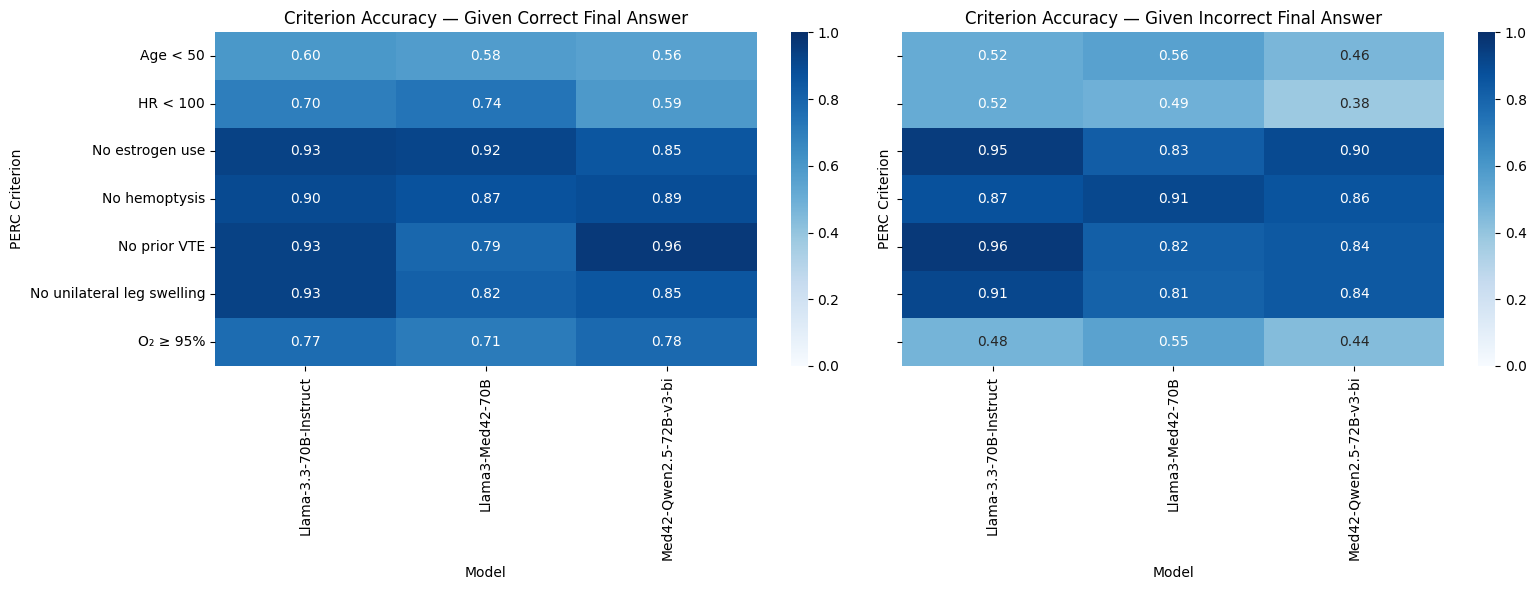

In [44]:
plot_criteria_accuracy_by_outcome(parsed_json, perc_df)


#### Criteria and Answer Accuracy

In [ ]:
'''Takes a parsed_json object (output from each model), Takes a patient_df (your DataFrame with patient notes and entities), Extracts and compares predicted vs actual PERC criteria, 
And produces pie charts showing how often models: Got all criteria right, Got one or more criteria wrong, Separately for correct and incorrect final predictions.'''
def plot_criteria_accuracy_pie(parsed_json, patient_df):
    def to_bool(val):
        if isinstance(val, bool):
            return val
        if isinstance(val, str):
            return val.lower() in ['true', 'yes', '1']
        return bool(val)

    def get_truth(entities):
        age = extract_number(entities.get("age"))
        hr = extract_number(entities.get("Heart Rate or Pulse"))
        o2 = extract_number(entities.get("O₂ saturation percentage"))
        return {
            "Age < 50": age is not None and age < 50,
            "HR < 100": hr is not None and hr < 100,
            "O₂ ≥ 95%": o2 is not None and o2 >= 95,
            "No hemoptysis": not to_bool(entities.get("Hemoptysis", False)),
            "No estrogen use": not to_bool(entities.get("Estrogen use", False)),
            "No prior VTE": not to_bool(entities.get("Prior VTE", False)),
            "No unilateral leg swelling": not to_bool(entities.get("Unilateral leg swelling", False)),
        }

    # Store counts separately for correct/incorrect predictions
    model_stats = {}

    for model_id, outputs in parsed_json.items():
        correct_all = 0
        correct_some = 0
        wrong_all = 0
        wrong_some = 0

        for i, output in enumerate(outputs):
            try:
                criteria_pred = output["parsed_criteria"]["Criteria"]
            except (TypeError, KeyError):
                continue

            row = patient_df.iloc[i]
            entities = row["Parsed Entities"]
            truth = get_truth(entities)

            match_flags = []
            for criterion, true_val in truth.items():
                pred_val = criteria_pred.get(criterion)
                if pred_val is None:
                    continue
                match_flags.append(pred_val == true_val)

            if not match_flags:
                continue  # Skip if we couldn't match anything

            if builtins.all(match_flags):
                if output.get("correct"):
                    correct_all += 1
                else:
                    wrong_all += 1
            else:
                if output.get("correct"):
                    correct_some += 1
                else:
                    wrong_some += 1

        model_stats[model_id] = {
            "correct": {
                "All Criteria Correct": correct_all,
                "One or More Incorrect": correct_some
            },
            "incorrect": {
                "All Criteria Correct": wrong_all,
                "One or More Incorrect": wrong_some
            }
        }

    # Plot 2 pie charts per model
    num_models = len(model_stats)
    fig, axes = plt.subplots(2, num_models, figsize=(6 * num_models, 12))

    if num_models == 1:
        axes = axes.reshape(2, 1)

    for col, (model_id, counts) in enumerate(model_stats.items()):
        for row_idx, key in enumerate(["correct", "incorrect"]):
            subset = counts[key]
            total = sum(subset.values())
            ax = axes[row_idx][col]

            if total == 0:
                ax.set_title(f"{model_id}\n(No {key} answers)")
                ax.axis("off")
                continue

            sizes = [subset["All Criteria Correct"], subset["One or More Incorrect"]]
            labels = ["All Criteria Correct", "One or More Incorrect"]
            colors = ["mediumseagreen", "tomato"]

            ax.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140)
            ax.set_title(f"{model_id} - {key.capitalize()}")

    plt.suptitle("Criteria Accuracy Breakdown per Model", fontsize=18)
    plt.tight_layout()
    plt.show()


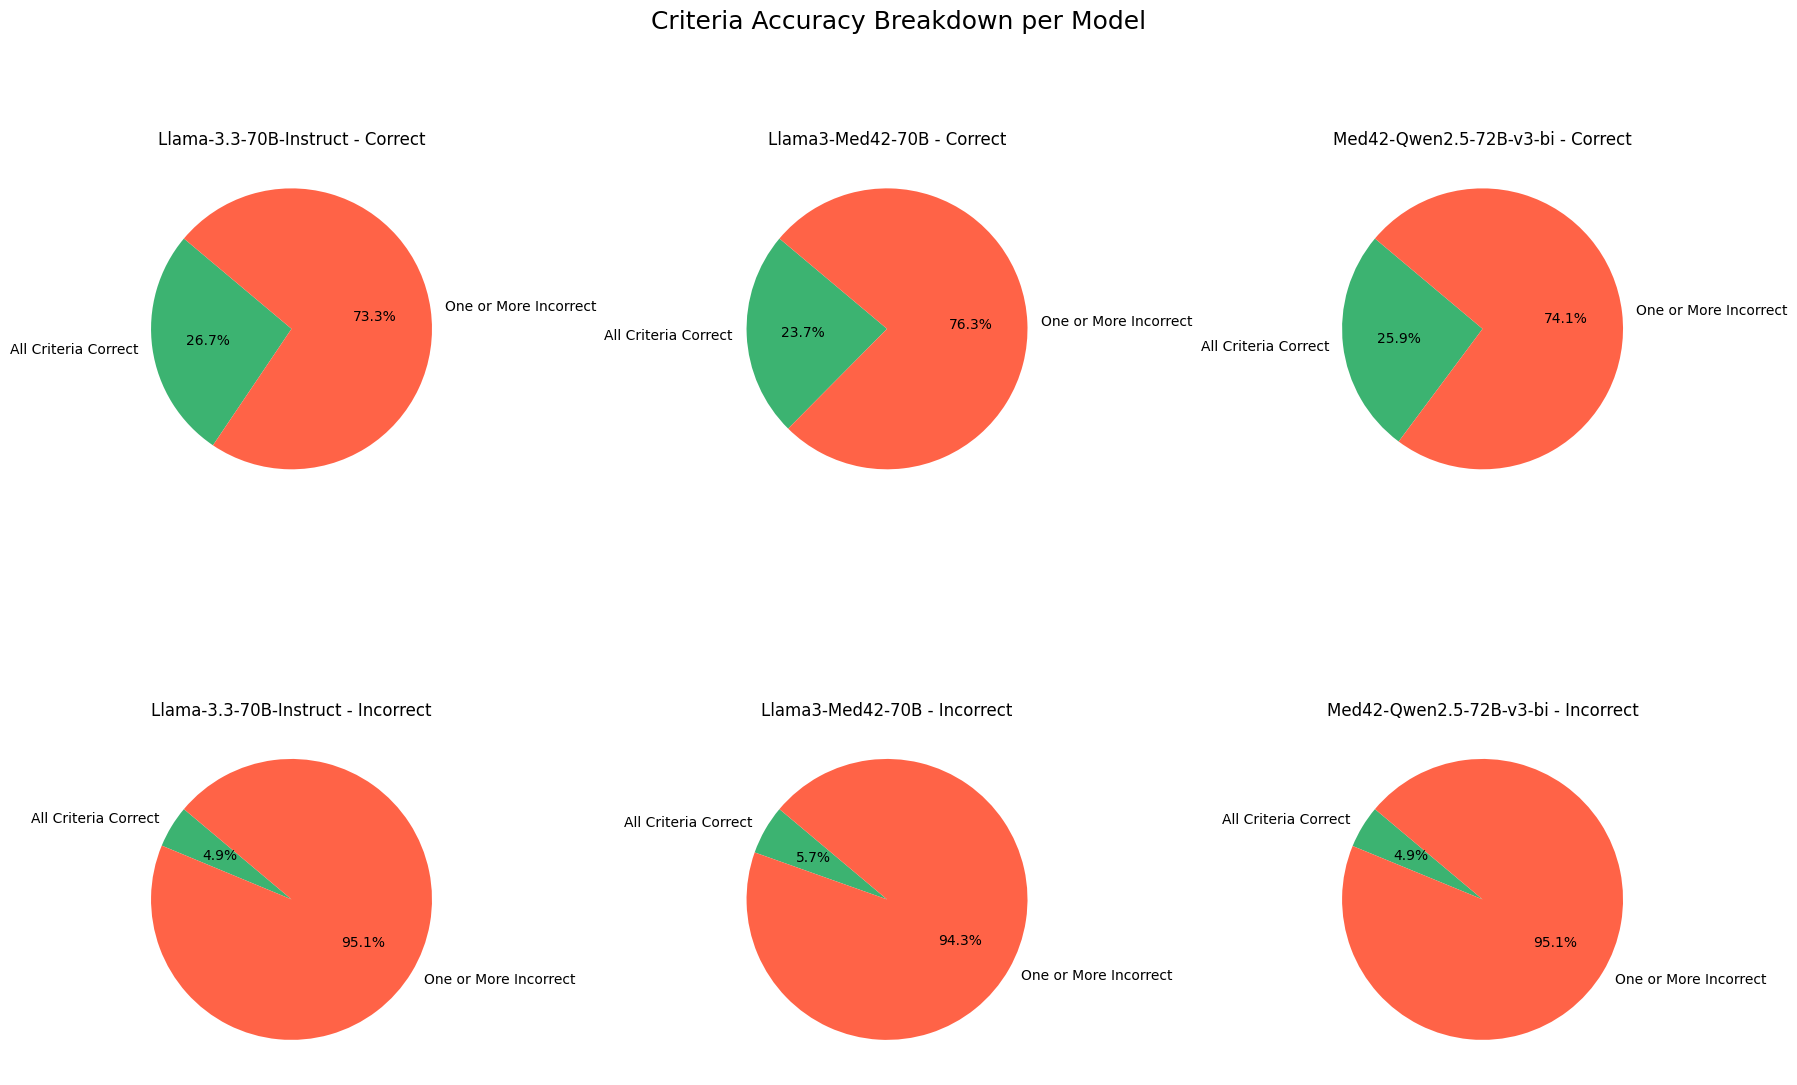

In [51]:
plot_criteria_accuracy_pie(parsed_json, perc_df)


In [ ]:
def llm(text:str) -> str:
    pass

def parser(text:str) -> dict:
    pass

def tool(args: dict) -> int:
    pass


def agent(input_message):
    '''  '''
    text_output = llm(input_message)
    json_dict = parser(text_output)
    perc_score = tool(json_dict)

    explanation = llm(f"{perc_score}")
    return perc_score


In [53]:
#Troubleshooting: wrong/invalud outputs
for i, entry in enumerate(wrong_outputs):
    print(f"\n--- Wrong Reply {i+1} ---")
    print(f"Expected: {entry['expected']} | Predicted: {entry['predicted']}")
    print(f"Reply:\n{entry['reply']}")

# Extract invalid replies with metadata
for i, entry in enumerate(invalid_outputs):
    print(f"\n--- Invalid Reply {i+1} ---")
    print(f"Expected: {entry['expected']} | Predicted: {entry['predicted']}")
    print(f"Reply:\n{entry['reply']}")

invalid_replies = [entry['reply'] for entry in invalid_outputs if 'reply' in entry]
for i, reply in enumerate(invalid_replies):
    print(f"\n--- Invalid Reply {i+1} ---\n{reply}")



--- Wrong Reply 1 ---
Expected: 3 | Predicted: 1
Reply:
To calculate the PERC score for this patient, we need to evaluate each of the 7 criteria based on the information provided in the patient note.

1. **Age < 50 years**: The patient is 65 years old, which is greater than 50. Therefore, this criterion is false.

2. **Heart rate < 100 bpm**: The patient's heart rate is 75 beats per minute, which is less than 100. Therefore, this criterion is true.

3. **Oxygen saturation ≥ 95%**: The patient's oxygen saturation is 95% on room air, which meets the criterion. Therefore, this criterion is true.

4. **No hemoptysis**: There is no mention of hemoptysis in the patient note. Therefore, this criterion is true.

5. **No estrogen use**: There is no mention of estrogen use in the patient note. Given the patient is a male, it is reasonable to assume this criterion is true.

6. **No prior venous thromboembolism (VTE)**: There is no mention of prior VTE in the patient note. Therefore, this criteri

In [81]:
def print_correct_with_wrong_criteria(parsed_json, patient_df):
    def to_bool(val):
        if isinstance(val, bool):
            return val
        if isinstance(val, str):
            return val.lower() in ['true', 'yes', '1']
        return bool(val)

    def get_truth(entities):
        age = extract_number(entities.get("age"))
        hr = extract_number(entities.get("Heart Rate or Pulse"))
        o2 = extract_number(entities.get("O₂ saturation percentage"))
        return {
            "Age < 50": age is not None and age < 50,
            "HR < 100": hr is not None and hr < 100,
            "O₂ ≥ 95%": o2 is not None and o2 >= 95,
            "No hemoptysis": not to_bool(entities.get("Hemoptysis", False)),
            "No estrogen use": not to_bool(entities.get("Estrogen use", False)),
            "No prior VTE": not to_bool(entities.get("Prior VTE", False)),
            "No unilateral leg swelling": not to_bool(entities.get("Unilateral leg swelling", False)),
        }

    count = 0

    for model_id, outputs in parsed_json.items():
        for i, output in enumerate(outputs):
            if not output.get("correct"):
                continue  # Only focus on correct predictions

            try:
                criteria_pred = output["parsed_criteria"]["Criteria"]
            except (TypeError, KeyError):
                continue

            row = patient_df.iloc[i]
            entities = row["Parsed Entities"]
            truth = get_truth(entities)

            wrong_criteria = []
            for criterion, true_val in truth.items():
                pred_val = criteria_pred.get(criterion)
                if pred_val is None:
                    continue
                if pred_val != true_val:
                    wrong_criteria.append(criterion)

            if wrong_criteria:
                count += 1
                print(f"\n--- Correct Answer with Wrong Criteria {count} ---")
                print(f"Model: {model_id}")
                print(f"Wrong Criteria: {wrong_criteria}")
                print(f"Expected (Ground Truth): {output.get('ground_truth')} | Predicted: {output.get('predicted')}")
                print(f"\nParsed Entities:\n{entities}")
                print(f"\nPatient Note:\n{row.get('Patient Note', 'N/A')}")
                print(f"\nReply:\n{output.get('raw_reply', 'N/A')}")

    if count == 0:
        print("✅ No correct predictions with incorrect criteria.")


In [65]:
print_correct_with_wrong_criteria(parsed_json, perc_df)



--- Correct Answer with Wrong Criteria 1 ---
Model: Llama-3.3-70B-Instruct
Wrong Criteria: ['Age < 50', 'O₂ ≥ 95%']
Expected (Ground Truth): 1 | Predicted: 1

Parsed Entities:
{'age': [28, 'years'], 'Previously Documented Pulmonary Embolism': False, 'Heart Rate or Pulse': [89.0, 'beats per minute'], 'Hemoptysis': False, 'O₂ saturation percentage': [94.0, '%'], 'Unilateral Leg Swelling': False, 'Hormone use': False, 'Recent surgery or trauma': False, 'Previously documented Deep Vein Thrombosis': False}

Patient Note:
A 28-year-old woman gave birth to a healthy male infant following a normal, uneventful vaginal delivery (gravida 10, para 8). The patient was admitted to the emergency department six days postpartum with the acute onset, two hours prior, of substernal chest pain radiating to the left arm and interscapular region. The patient had no coronary risk factors such as hypertension, diabetes, or dyslipidemia, had no family history of heart disease, and did not have a history of or

In [ ]:
sys_instruct = (
    "You are a clinical decision support assistant. You always follow structured clinical decision rules and explain your reasoning before giving a final structured JSON answer.\n"
)
invalid_outputs, wrong_outputs, results_df,parsed_json = await run_models_with_output(
    sys_instruct = sys_instruct
    ,prompt= "Your task is to calculate the PERC (Pulmonary Embolism Rule-out Criteria) score for a patient using the note and extracted entities provided.\n"
    "\n"
    "There are 7 criteria. Each one is evaluated as either true (criterion met) or false (criterion not met). Each false criterion adds 1 point to the PERC score.\n"
    "\n"
    "PERC Criteria:\n"
    "1. Age < 50 years\n"
    "2. Heart rate < 100 bpm\n"
    "3. Oxygen saturation ≥ 95%\n"
    "4. No hemoptysis\n"
    "5. No estrogen use\n"
    "6. No prior venous thromboembolism (VTE)\n"
    "7. No unilateral leg swelling\n"
    "\n"
    "After your output return a **single JSON object*.\n"
    "\n"
    "Format:\n"

    "First explain the decision making process , interpret and analyze the patient's note"

    "After you reach your answer, put your final decision in the output below:"
    "{\n"
    "  \"Explanation\": \"<A short explanation of how each criterion was evaluated>\",\n"
    "  \"Criteria\": {\n"
    "    \"Age < 50\": true or false,\n"
    "    \"HR < 100\": true or false,\n"
    "    \"O₂ ≥ 95%\": true or false,\n"
    "    \"No hemoptysis\": true or false,\n"
    "    \"No estrogen use\": true or false,\n"
    "    \"No prior VTE\": true or false,\n"
    "    \"No unilateral leg swelling\": true or false\n"
    "  },\n"
    "  \"Answer\": <sum of false values>\n"
    "}\n",
    model_ids=["Llama-3.3-70B-Instruct"],
    include_relevant_entities=False,
    full_df=True
)



=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Summary Table ===
                 model_id  wrong  correct  invalid  total  accuracy
0  Llama-3.3-70B-Instruct     99       34        0    133     0.256


In [ ]:
sys_instruct = (
    "You are a clinical decision support assistant. You always follow structured clinical decision rules and explain your reasoning before giving a final structured JSON answer.\n"
    "Your task is to calculate the PERC (Pulmonary Embolism Rule-out Criteria) score for a patient using the note and extracted entities provided.\n"
    "\n"
    "There are 7 criteria. Each one is evaluated as either true (criterion met) or false (criterion not met). Each false criterion adds 1 point to the PERC score.\n"
    "\n"
    "PERC Criteria:\n"
    "1. Age < 50 years\n"
    "2. Heart rate < 100 bpm\n"
    "3. Oxygen saturation ≥ 95%\n"
    "4. No hemoptysis\n"
    "5. No estrogen use\n"
    "6. No prior venous thromboembolism (VTE)\n"
    "7. No unilateral leg swelling\n"
    "\n"
    "After your output return a **single JSON object*.\n"
    "\n"
    "Format:\n"

    "First explain the decision making process , interpret and analyze the patient's note"

    "After you reach your answer, put your final decision in the output below:"
    # "{\n"
    # "  \"Explanation\": \"<A short explanation of how each criterion was evaluated>\",\n"
    # "  \"Criteria\": {\n"
    # "    \"Age < 50\": true or false,\n"
    # "    \"HR < 100\": true or false,\n"
    # "    \"O₂ ≥ 95%\": true or false,\n"
    # "    \"No hemoptysis\": true or false,\n"
    # "    \"No estrogen use\": true or false,\n"
    # "    \"No prior VTE\": true or false,\n"
    # "    \"No unilateral leg swelling\": true or false\n"
    # "  },\n"
    "  {\"Answer\": <sum of false criteria>}\n"
)
invalid_outputs, wrong_outputs, results_df,parsed_json = await run_models_with_output(
    sys_instruct = sys_instruct
    ,prompt= "Your task is to calculate the PERC (Pulmonary Embolism Rule-out Criteria) score for a patient using the note and extracted entities provided.\n"
    "\n"
    "There are 7 criteria. Each one is evaluated as either true (criterion met) or false (criterion not met). Each false criterion adds 1 point to the PERC score.\n"
    "\n"
    "PERC Criteria:\n"
    "1. Age < 50 years\n"
    "2. Heart rate < 100 bpm\n"
    "3. Oxygen saturation ≥ 95%\n"
    "4. No hemoptysis\n"
    "5. No estrogen use\n"
    "6. No prior venous thromboembolism (VTE)\n"
    "7. No unilateral leg swelling\n"
    "\n"
    "After your output return a **single JSON object*.\n"
    "\n"
    "Format:\n"

    "First explain the decision making process , interpret and analyze the patient's note"

    "After you reach your answer, put your final decision in the output below:"
    "{\n"
    "  \"Explanation\": \"<A short explanation of how each criterion was evaluated>\",\n"
    "  \"Criteria\": {\n"
    "    \"Age < 50\": true or false,\n"
    "    \"HR < 100\": true or false,\n"
    "    \"O₂ ≥ 95%\": true or false,\n"
    "    \"No hemoptysis\": true or false,\n"
    "    \"No estrogen use\": true or false,\n"
    "    \"No prior VTE\": true or false,\n"
    "    \"No unilateral leg swelling\": true or false\n"
    "  },\n"
    "  \"Answer\": <sum of false criteria>}\n"
    "}\n",
    model_ids=["Llama-3.3-70B-Instruct"],
    include_relevant_entities=True,
    full_df=True
)




=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Summary Table ===
                 model_id  wrong  correct  invalid  total  accuracy
0  Llama-3.3-70B-Instruct    103       30        0    133     0.226


### Using Jinja

In [ ]:
from jinja2 import Environment, DictLoader

template_str = """
{% if include_relevant_entities %}
Relevant Entities:
{{ entities }}

{% endif %}
Patient Note:
{{ note }}

{{ prompt }}
"""

env = Environment(loader=DictLoader({'perc_prompt': template_str}))
template = env.get_template('perc_prompt')


In [129]:
''' A function that runs models with output.
It takes a system instruction, a list of model IDs, and optional parameters for including relevant entities,
sampling, and full DataFrame usage.
It returns invalid outputs, wrong outputs, a summary DataFrame, and parsed results per model.'''
async def run_models_with_output_with_jinja(
    sys_instruct,
    model_ids: List[str],
    include_relevant_entities=True,
    sample=10,
    full_df=False,
    prompt="Calculate PERC score for this patient."
):
    results = []
    wrong_outputs = []
    invalid_outputs = []
    parsed_results_per_model = {model_id: [] for model_id in model_ids}

    subset_df = perc_df.head(sample)
    iterate_df = perc_df if full_df else subset_df

    for model_id in model_ids:
        print(f"\n=== Evaluating model: {model_id} ===\n")
        wrong = invalid = correct = 0
        total = len(iterate_df)
        prompts = []

        for idx, row in iterate_df.iterrows():
            entities = entities = ast.literal_eval(row["Relevant Entities"]) if include_relevant_entities else None
            user_instruction = template.render(
                note=row["Patient Note"],
                entities=row["Parsed Entities"],
                include_relevant_entities=include_relevant_entities,
                prompt=prompt
            )
            prompts.append(user_instruction)


        results_async = await run_batch(
            model=model_id,
            system_instruction=sys_instruct,
            prompts=prompts
        )

        for i, reply in enumerate(results_async):
            progress = (i + 1) / len(results_async) * 100
            print(f"\rParsing: {progress:.1f}% ({i + 1}/{len(results_async)})", end="", flush=True)

            row = iterate_df.iloc[i]
            entities = row["Parsed Entities"]
            ground_truth = row["Ground Truth Answer"]

            parsed = extract_json_from_text(reply)
            if parsed is None or "Answer" not in parsed:
                # parsed = extract_score_from_text(reply) 
                if parsed is None or "Answer" not in parsed:
                    invalid += 1
                    invalid_outputs.append({
                        "model": model_id,
                        "note": row["Patient Note"],
                        "entities": entities if include_relevant_entities else None,
                        "reply": reply,
                        "reason": "Invalid JSON or missing 'Answer'"
                    })
                    parsed_results_per_model[model_id].append({
                        "note": row["Patient Note"],
                        "entities": entities if include_relevant_entities else None,
                        "ground_truth": ground_truth,
                        "parsed_criteria": None,
                        "predicted": None,
                        "raw_reply": reply,
                        "valid": False,
                        "correct": False
                    })
                    continue

            predicted_score = parsed.get("Answer")

            # Extract all criteria booleans except the 'Answer'
            criteria = {k: v for k, v in parsed.items() if k != "Answer"}

            if predicted_score == ground_truth:
                correct += 1
            else:
                wrong += 1
                wrong_outputs.append({
                    "model": model_id,
                    "note": row["Patient Note"],
                    "entities": entities if include_relevant_entities else None,
                    "reply": reply,
                    "expected": ground_truth,
                    "predicted": predicted_score
                })

            parsed_results_per_model[model_id].append({
                "note": row["Patient Note"],
                "entities": entities if include_relevant_entities else None,
                "ground_truth": ground_truth,
                "parsed_criteria": criteria,
                "predicted": predicted_score,
                "raw_reply": reply,
                "valid": True,
                "correct": predicted_score == ground_truth
            })

        valid = correct + wrong
        accuracy = correct / valid if valid > 0 else 0

        results.append({
            "model_id": model_id,
            "wrong": wrong,
            "correct": correct,
            "invalid": invalid,
            "total": total,
            "accuracy": round(accuracy, 3)
        })

        print("\nDone ✅")

    results_df = pd.DataFrame(results)
    print("\n=== Summary Table ===")
    print(results_df)

    return invalid_outputs, wrong_outputs, results_df, parsed_results_per_model


In [130]:
sys_instruct = (
    "You are a clinical decision support assistant. You always follow structured clinical decision rules and explain your reasoning before giving a final structured JSON answer.\n"
    "Your task is to calculate the PERC (Pulmonary Embolism Rule-out Criteria) score for a patient using the note and extracted entities provided.\n"
    "\n"
    "There are 7 criteria. Each one is evaluated as either true (criterion met) or false (criterion not met). Each false criterion adds 1 point to the PERC score.\n"
    "\n"
    "PERC Criteria:\n"
    "1. Age < 50 years\n"
    "2. Heart rate < 100 bpm\n"
    "3. Oxygen saturation ≥ 95%\n"
    "4. No hemoptysis\n"
    "5. No estrogen use\n"
    "6. No prior venous thromboembolism (VTE)\n"
    "7. No unilateral leg swelling\n"
    "\n"
    "After your output return a **single JSON object*.\n"
    "\n"
    "Format:\n"

    "First explain the decision making process , interpret and analyze the patient's note"

    "After you reach your answer, put your final decision in the output below:"
    # "{\n"
    # "  \"Explanation\": \"<A short explanation of how each criterion was evaluated>\",\n"
    # "  \"Criteria\": {\n"
    # "    \"Age < 50\": true or false,\n"
    # "    \"HR < 100\": true or false,\n"
    # "    \"O₂ ≥ 95%\": true or false,\n"
    # "    \"No hemoptysis\": true or false,\n"
    # "    \"No estrogen use\": true or false,\n"
    # "    \"No prior VTE\": true or false,\n"
    # "    \"No unilateral leg swelling\": true or false\n"
    # "  },\n"
    "  {\"Answer\": <sum of false criteria>}\n"
)
invalid_outputs, wrong_outputs, results_df,parsed_json = await run_models_with_output_with_jinja(
    sys_instruct = sys_instruct
    ,prompt= "Your task is to calculate the PERC (Pulmonary Embolism Rule-out Criteria) score for a patient using the note and extracted entities provided.\n"
    "\n"
    "There are 7 criteria. Each one is evaluated as either true (criterion met) or false (criterion not met). Each false criterion adds 1 point to the PERC score.\n"
    "\n"
    "PERC Criteria:\n"
    "1. Age < 50 years\n"
    "2. Heart rate < 100 bpm\n"
    "3. Oxygen saturation ≥ 95%\n"
    "4. No hemoptysis\n"
    "5. No estrogen use\n"
    "6. No prior venous thromboembolism (VTE)\n"
    "7. No unilateral leg swelling\n"
    "\n"
    "After your output return a **single JSON object*.\n"
    "\n"
    "Format:\n"

    "First explain the decision making process , interpret and analyze the patient's note"

    "After you reach your answer, put your final decision in the output below:"
    "{\n"
    "  \"Explanation\": \"<A short explanation of how each criterion was evaluated>\",\n"
    "  \"Criteria\": {\n"
    "    \"Age < 50\": true or false,\n"
    "    \"HR < 100\": true or false,\n"
    "    \"O₂ ≥ 95%\": true or false,\n"
    "    \"No hemoptysis\": true or false,\n"
    "    \"No estrogen use\": true or false,\n"
    "    \"No prior VTE\": true or false,\n"
    "    \"No unilateral leg swelling\": true or false\n"
    "  },\n"
    "  \"Answer\": <sum of false criteria>}\n"
    "}\n",
    model_ids=["Llama-3.3-70B-Instruct"],
    include_relevant_entities=True,
    full_df=True
)




=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 57.1% (76/133)

TimeoutError: 